In [1]:
import glob
import pandas as pd
import numpy as np
import os, sys
import collections
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier 

In [3]:
from numba.typed import List
from numba import jit, njit, vectorize

In [4]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [5]:
sample_rate = 50  # number of observation per second based on dataset documentation(150 samples in 3 second)

sliding_size = int((1/3) * sample_rate)  # number of skipped datapoints to start next window
print(sliding_size)

16


# Feature sets

In [6]:
@njit()
def mean_crossing_rate(col):
    # col = np.array(values)
    normalized = col - col.mean()  # to make elements of array possitive or negetive
    return ((normalized[:-1] * col[1:]) < 0).sum()  # Zero-Crossing_rate

@njit()
def iqr(window):  # inter-quartile range
    Q1 = np.median(window[:len(window)//2])  # First quartile (Q1) 
    Q3 = np.median(window[len(window)//2:])  # Third quartile (Q3) 
    IQR = Q3 - Q1 # Interquartile range (IQR) 
    return(IQR) 
@njit()
def calc_sma_for_window(data):
    return np.sum(data) / len(data)  
@njit()
def get_min(x):
    m = np.min(x)
    return m
@njit()
def get_max(x):
    m = np.max(x)
    return m
@njit()
def get_mean(x):
    m = np.mean(x)
    return m
@njit()
def get_var(x):
    m = np.var(x)
    return m
@njit()
def get_mean(x):
    m = np.mean(x)
    return m
@njit()
def get_sum(x):
    m = x.sum()
    return m 
@njit()
def get_median(x):
    m = np.median(x)
    return m 
@njit()
def get_std(x):
    m = np.median(x)
    return m 
@njit()
def get_rng(x):
    n = np.max(x)
    m = np.min(x)
    z = n-m
    return z 

def get_rms(x, axis=None):
    return np.sqrt(np.mean(x ** 2, axis=axis))

def calc_sma_for_window(data):
    return np.sum(data) / len(data)


def calc_sma_adv_for_window(data):
    return np.sum(data - np.mean(data) / len(data))


def calc_absolutes_for_list(list):
    return ([abs(i) for i in list])

def get_sma(data): 
    sma_sim = calc_sma_for_window(data)
    sma_adv = calc_sma_adv_for_window(data)

    sma_sim_abs = calc_sma_for_window(calc_absolutes_for_list(data))
    sma_adv_abs = calc_sma_adv_for_window(calc_absolutes_for_list(data))

    return sma_sim, sma_adv, sma_sim_abs, sma_adv_abs

def get_entropy(Y):
    """
    Also known as Shanon Entropy
    Reference: https://en.wikipedia.org/wiki/Entropy_(information_theory)
    """
    unique, count = np.unique(Y, return_counts=True, axis=0)
    prob = count/len(Y)
    en = np.sum((-1)*prob*np.log2(prob))
    return en

In [7]:
def Energy(frame):
    return sum( [ abs(x)**2 for x in frame ] ) / len(frame)

# Feature extraction

In [8]:
def Features(window):# mean, std,max,min and zero-crossing-rate
    wind = window.iloc[:, :-1]
    win = np.array(wind)
    features = []
    
    features.append(get_mean(win))
    features.append(get_median(win))
    features.append(get_std(win))
    features.append(get_min(win))
    features.append(get_max(win))
    features.append(get_sum(win))
    features.append(get_entropy(win))
    mean_crossing = [mean_crossing_rate(win[:, i]) for i in range(win.shape[1])]
    features.append(np.array(mean_crossing))
    IQR = iqr(win)
    features.append(np.array(IQR))
    energy_measure = Energy(win)
    features.append(np.array(energy_measure))
 

    
    features = np.hstack(features).tolist()
    
    label = window.iloc[:, -1].mode()[0]  ## select the most frequent label as the label of the window
    features.append(label)
    return features

In [9]:
def windowing_dataset(dataset, win_size, feature_extraction_function, subject_id, overlap=False):
    windowed_dataset = []
    win_count = 0
    if overlap:
        step_size = sliding_size  # for Overlapping technique
    else:
        step_size = win_size  # for Non-overlapping technique

    for index in range(0, dataset.shape[0], step_size):
        start = index
        end = start + win_size
        # to assure all of windows are equal in size
        if (end <= dataset.shape[0]):
            window = dataset.iloc[start:end, :].reset_index(drop=True)
            win_count = win_count + 1
            features = feature_extraction_function(window)

            windowed_dataset.append(features)

    final = pd.DataFrame(windowed_dataset)
    final.insert(0, 'group', subject_id)  # to use in Subject CV
    return final

In [10]:
def Preprocessing(dataset_path, overlapping):
    feature_function = Features
    win_size = 3

    print("Start for win size {}".format(win_size))
    datapoints_per_window = int(win_size * sample_rate)

    print(feature_function.__name__)

    ACC = []
    GYR = []
    MAG = []
    QUAD = []

    for subject in range(1,18):
        file_path = dataset_path + '\subject{0}_ideal.csv'.format(subject)
        acc_cols = []
        gyr_cols = []
        mag_cols = []
        quad_cols = []
        
#########################################################################################################################
        for i in range(2, 117, 13):# indices of accelarations
            indices = list(range(i, i + 3))
            acc_cols.extend(indices)

        acc_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=acc_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        ACC.append(transformed_db)
#########################################################################################################################
        for i in range(5, 117, 13):# indices of gyr
            indices = list(range(i, i + 3))
            gyr_cols.extend(indices)

        gyr_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=gyr_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        GYR.append(transformed_db)
#########################################################################################################################        
        for i in range(8, 117, 13):# indices of mag
            indices = list(range(i, i + 3))
            mag_cols.extend(indices)

        mag_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=mag_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        MAG.append(transformed_db)
#########################################################################################################################
        for i in range(11, 117, 13):# indices of quad
            indices = list(range(i, i + 4))
            quad_cols.extend(indices)

        quad_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=quad_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        QUAD.append(transformed_db)
#########################################################################################################################
    #final_dataset = pd.DataFrame()
    ACC_dataset = pd.DataFrame()
    GYR_dataset = pd.DataFrame()
    MAG_dataset = pd.DataFrame()
    QUAD_dataset= pd.DataFrame()
    ACC_dataset = ACC_dataset.append(ACC, ignore_index=True)
    GYR_dataset = GYR_dataset.append(GYR, ignore_index=True)
    MAG_dataset = MAG_dataset.append(MAG, ignore_index=True)
    QUAD_dataset = QUAD_dataset.append(QUAD, ignore_index=True)
    return ACC_dataset,GYR_dataset,MAG_dataset,QUAD_dataset
   

In [11]:
def subject_cross_validation(X, Y, groups, classifier):
    f1 = []
    logo = LeaveOneGroupOut()
    i = 0

    for train_index, test_index in logo.split(X, Y, groups=groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        i += 1
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_test)
        f = f1_score(y_true=y_test, y_pred=y_pred, average='micro')
        
        print('Model-',i ,' -',' f1 score: ', f)
       
        f1.append(f)
    return np.mean(f1)

# Vector_Normalization_and_mean_removal on features

In [12]:
def classifier(dataset, model):
    results = dict()
    win_size = float(3)
    print('window_size = ', win_size,' sec')

    dataset = dataset
    groups = dataset['group']
    X = dataset.iloc[:, 1:-1]
    X = np.array(X)
    data_normalized = preprocessing.normalize(X, norm  = 'l1') # Vector_Normalization on features
    X = data_normalized
    data_standardized = preprocessing.scale(X) # mean removal on features after extraction
    X = data_standardized
    
    Y = dataset.iloc[:, -1]
    Y = np.array(Y)

    for model_name, mod in model.items():
        f1 = 0

        f1 = subject_cross_validation(X, Y, groups, mod)

        if win_size in results:
            results[win_size].append(f1)
        else:
            results[win_size] = [f1]


        results = collections.OrderedDict(sorted(results.items()))

        final = []
        col = list(model.keys())
        col.insert(0, "window-size")
        final.append(col)
        for k, v in results.items():
            tmp = []
            tmp.append([k])
            tmp.append(v)
            flattened = [val for sublist in tmp for val in sublist]
            final.append(flattened)

    accuracy = final[1][1]
    print(accuracy)
    return accuracy

In [13]:
mod = {'RF': RandomForestClassifier(n_estimators=40, random_state=0, n_jobs=-1)}

In [14]:
dataset_csv_path = r"D:\projec\proj\data"

overlapping = 1  # input 0 for non overlapping, 1 for overlapping

ACC, GYR,MAG,QUAD = Preprocessing(dataset_path=dataset_csv_path, overlapping=bool(int(overlapping)))

Start for win size 3
Features


In [15]:
ACC.head(10)

,group,0,1,2,3,4,5,6,7,8,...,53,54,55,56,57,58,59,60,61,62
0,1,-1.732504,-1.29170,-1.29170,-13.572,13.123,-7016.640892,7.228819,51.0,73.0,...,97.596896,2.614483,3.972490,91.216357,4.908053,6.924065,103.030082,2.128669,10.592659,1
1,1,-1.737506,-1.39335,-1.39335,-13.572,13.123,-7036.899082,7.228819,54.0,82.0,...,96.336952,2.841184,4.262778,89.087603,4.784476,6.141604,104.972342,2.112725,9.614629,1
2,1,-1.760287,-1.49575,-1.49575,-13.572,13.123,-7129.162488,7.228819,55.0,84.0,...,96.706927,3.186290,4.960502,91.225952,5.414425,7.102094,102.463140,2.243333,8.306392,1
3,1,-1.817356,-1.50710,-1.50710,-13.547,10.304,-7360.291312,7.228819,27.0,90.0,...,96.023806,3.244764,4.420953,90.805815,5.722863,8.120603,101.219592,2.329946,6.172700,1
4,1,-1.868875,-1.46245,-1.46245,-13.547,12.127,-7568.942724,7.228819,22.0,95.0,...,93.524969,2.865460,3.740188,89.404817,5.194657,7.560791,103.145691,2.210087,7.435001,1
5,1,-1.980536,-1.43575,-1.43575,-16.693,13.038,-8021.170428,7.228819,37.0,90.0,...,99.468029,3.197251,3.869554,92.976167,5.174020,8.676409,104.952384,2.257042,10.627171,1
6,1,-2.094534,-1.47645,-1.47645,-16.693,13.038,-8482.863345,7.228819,42.0,76.0,...,97.836846,3.421327,3.389102,92.298280,5.047260,7.979224,103.759106,2.306964,10.315249,1
7,1,-2.255009,-1.56815,-1.56815,-17.479,18.240,-9132.786609,7.228819,47.0,54.0,...,98.735858,4.008570,5.465186,90.591707,4.946968,7.853299,106.001077,2.320153,9.489608,1
8,1,-2.413172,-1.56815,-1.56815,-18.348,18.240,-9773.344678,7.228819,51.0,56.0,...,98.134371,4.736857,5.513315,95.955879,5.414790,9.090559,102.025488,2.495885,8.519354,1
9,1,-2.575517,-1.61770,-1.61770,-18.348,18.240,-10430.844760,7.228819,53.0,58.0,...,97.243212,4.373304,5.380244,92.505768,4.811498,9.747096,106.358770,2.405943,11.882449,1


In [16]:
GYR.head(10)

,group,0,1,2,3,4,5,6,7,8,...,53,54,55,56,57,58,59,60,61,62
0,1,-0.003306,-0.003194,-0.003194,-3.8842,2.5941,-13.389730,7.228819,24.0,9.0,...,0.446450,0.861571,0.154990,0.702863,0.867479,0.071608,0.581025,3.433057,0.096471,1
1,1,-0.010352,-0.011482,-0.011482,-3.8842,2.8503,-41.925927,7.228819,31.0,13.0,...,0.566303,1.028272,0.145689,0.524904,0.580337,0.066339,0.405566,2.955452,0.095075,1
2,1,-0.000118,-0.009252,-0.009252,-3.8842,2.8503,-0.479570,7.228819,28.0,9.0,...,0.594551,0.978982,0.152470,0.530946,0.598696,0.060429,0.293327,2.090189,0.071682,1
3,1,-0.001233,-0.006229,-0.006229,-3.8842,2.8503,-4.991931,7.228819,62.0,7.0,...,0.618125,1.027758,0.184730,0.625833,0.875417,0.066227,0.489479,2.260539,0.066683,1
4,1,-0.002894,-0.000136,-0.000136,-3.8842,2.8503,-11.719913,7.228819,54.0,10.0,...,0.485814,0.712784,0.146640,0.674918,0.910137,0.058095,0.638540,3.138315,0.075594,1
5,1,0.004653,0.013085,0.013085,-4.7759,4.2227,18.845503,7.228819,45.0,11.0,...,0.549750,0.867242,0.185429,0.696938,0.906484,0.073080,0.688235,3.324015,0.098932,1
6,1,0.000666,0.002609,0.002609,-4.7759,7.1059,2.696189,7.228819,57.0,11.0,...,0.680166,1.041968,0.176200,0.698976,0.966406,0.077637,0.687802,3.237408,0.099800,1
7,1,-0.002524,-0.001852,-0.001852,-5.3323,7.1059,-10.221902,7.228819,35.0,11.0,...,0.722951,1.016965,0.169287,0.558895,0.663725,0.069437,0.566323,3.112343,0.092486,1
8,1,0.008876,0.003892,0.003892,-5.3323,7.1059,35.948276,7.228819,26.0,11.0,...,0.747123,0.984564,0.192129,0.588822,0.957663,0.079776,0.602686,2.196212,0.069423,1
9,1,0.007054,0.016663,0.016663,-5.3323,7.1059,28.569672,7.228819,33.0,9.0,...,0.791262,1.101351,0.181426,0.669305,1.036284,0.065181,0.756385,3.605017,0.084708,1


In [17]:
MAG.head(10)

,group,0,1,2,3,4,5,6,7,8,...,53,54,55,56,57,58,59,60,61,62
0,1,0.122687,0.054137,0.054137,-0.48366,0.87089,496.881671,7.228819,90.0,68.0,...,0.357448,0.003657,0.016382,0.622709,0.003304,0.039999,0.409673,0.065249,0.081963,1
1,1,0.122757,0.057163,0.057163,-0.47624,0.87089,497.163854,7.228819,79.0,60.0,...,0.357240,0.003706,0.018390,0.619513,0.003458,0.041156,0.413741,0.068959,0.064359,1
2,1,0.122488,0.058662,0.058662,-0.48879,0.87089,496.077094,7.228819,75.0,64.0,...,0.357556,0.003362,0.021844,0.613512,0.003560,0.055832,0.437328,0.062415,0.059816,1
3,1,0.124067,0.056789,0.056789,-0.54691,0.87089,502.472614,7.228819,22.0,68.0,...,0.360712,0.003069,0.020669,0.619554,0.003909,0.061742,0.459112,0.052358,0.067397,1
4,1,0.123859,0.051037,0.051037,-0.88797,0.87089,501.629499,7.228819,15.0,132.0,...,0.365645,0.003815,0.019958,0.622811,0.003878,0.059275,0.467472,0.047577,0.067944,1
5,1,0.132113,0.053992,0.053992,-0.90571,1.15230,535.056464,7.228819,122.0,120.0,...,0.370472,0.004258,0.017924,0.626765,0.003271,0.053164,0.452130,0.049836,0.075622,1
6,1,0.144107,0.061380,0.061380,-0.90571,1.28550,583.632754,7.228819,109.0,115.0,...,0.368724,0.004034,0.017406,0.640130,0.002997,0.042975,0.440110,0.051009,0.077333,1
7,1,0.148660,0.064782,0.064782,-0.90571,1.28550,602.073996,7.228819,94.0,77.0,...,0.366515,0.003950,0.020518,0.631268,0.002740,0.048118,0.455538,0.052813,0.058612,1
8,1,0.162770,0.084191,0.084191,-0.90571,1.60600,659.219834,7.228819,80.0,45.0,...,0.364613,0.003329,0.022959,0.628192,0.002816,0.056832,0.463414,0.048845,0.073784,1
9,1,0.171879,0.080777,0.080777,-0.90571,1.64620,696.108205,7.228819,66.0,93.0,...,0.365145,0.003643,0.020482,0.629799,0.004148,0.056577,0.479525,0.042276,0.069691,1


In [18]:
QUAD.head(10)

,group,0,1,2,3,4,5,6,7,8,...,71,72,73,74,75,76,77,78,79,80
0,1,0.179565,0.305880,0.305880,-0.82507,0.92828,969.649936,7.228819,74.0,72.0,...,0.309986,0.239424,0.368558,0.199875,0.192142,0.060492,0.428163,0.104005,0.407340,1
1,1,0.177629,0.304765,0.304765,-0.82507,0.92828,959.197224,7.228819,71.0,85.0,...,0.308723,0.246330,0.367463,0.205245,0.180962,0.058963,0.406512,0.092348,0.442178,1
2,1,0.175552,0.302600,0.302600,-0.82507,0.92828,947.978413,7.228819,66.0,85.0,...,0.320409,0.230550,0.393196,0.210855,0.165398,0.050159,0.424356,0.094437,0.431047,1
3,1,0.176839,0.304345,0.304345,-0.82507,0.92828,954.931475,7.228819,39.0,102.0,...,0.339911,0.215048,0.410869,0.207537,0.166545,0.045673,0.462147,0.108078,0.384102,1
4,1,0.176758,0.307760,0.307760,-0.82507,0.92734,954.491426,7.228819,32.0,104.0,...,0.345556,0.214677,0.404292,0.204040,0.176991,0.051054,0.470697,0.113735,0.364515,1
5,1,0.174786,0.309115,0.309115,-0.83466,0.92552,943.842532,7.228819,45.0,100.0,...,0.326872,0.222987,0.388500,0.206179,0.182333,0.054213,0.458554,0.109609,0.377625,1
6,1,0.171296,0.308885,0.308885,-0.85207,0.92071,925.000170,7.228819,56.0,95.0,...,0.316581,0.233326,0.372511,0.209016,0.185147,0.055490,0.446425,0.105752,0.392333,1
7,1,0.165050,0.306390,0.306390,-0.89038,0.92071,891.272415,7.228819,68.0,85.0,...,0.313715,0.234124,0.374666,0.215947,0.175264,0.055669,0.429769,0.098172,0.416389,1
8,1,0.161557,0.303030,0.303030,-0.89038,0.92071,872.406107,7.228819,81.0,82.0,...,0.325013,0.217865,0.394589,0.219389,0.168157,0.048486,0.451738,0.104297,0.395479,1
9,1,0.160883,0.306680,0.306680,-0.89038,0.92071,868.765790,7.228819,94.0,91.0,...,0.332346,0.215210,0.392363,0.218895,0.173532,0.051493,0.466764,0.110999,0.370745,1


In [19]:
print('ACC_accuracy = ', )
ACC_accuracy = classifier(dataset=ACC, model=mod)
ACC_accuracy 

ACC_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.8846153846153846
Model- 2  -  f1 score:  0.9756785336623194
Model- 3  -  f1 score:  0.9156
Model- 4  -  f1 score:  0.9329967875172097
Model- 5  -  f1 score:  0.9213793103448276
Model- 6  -  f1 score:  0.9627777777777777
Model- 7  -  f1 score:  0.9584487534626038
Model- 8  -  f1 score:  0.9473886328725039
Model- 9  -  f1 score:  0.9494017094017094
Model- 10  -  f1 score:  0.8613861386138614
Model- 11  -  f1 score:  0.96125
Model- 12  -  f1 score:  0.9239949748743719
Model- 13  -  f1 score:  0.8447643240191928
Model- 14  -  f1 score:  0.8409010911650827
Model- 15  -  f1 score:  0.8601126028583802
Model- 16  -  f1 score:  0.8283418553688824
Model- 17  -  f1 score:  0.8832255610498289
0.9089566728002315


0.9089566728002315

In [20]:
print('GYR_accuracy = ', )
GYR_accuracy = classifier(dataset=GYR, model=mod)
GYR_accuracy

GYR_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.920979020979021
Model- 2  -  f1 score:  0.9675713782164258
Model- 3  -  f1 score:  0.908
Model- 4  -  f1 score:  0.9274896741624599
Model- 5  -  f1 score:  0.9265517241379311
Model- 6  -  f1 score:  0.9
Model- 7  -  f1 score:  0.9279778393351801
Model- 8  -  f1 score:  0.9182027649769585
Model- 9  -  f1 score:  0.9641025641025641
Model- 10  -  f1 score:  0.9651758279276204
Model- 11  -  f1 score:  0.9365625
Model- 12  -  f1 score:  0.9280778894472361
Model- 13  -  f1 score:  0.8837143663561953
Model- 14  -  f1 score:  0.9531854980640619
Model- 15  -  f1 score:  0.9346037245560849
Model- 16  -  f1 score:  0.8119065010956904
Model- 17  -  f1 score:  0.9106124001521491
0.9226302160887987


0.9226302160887987

In [21]:
print('MAG_accuracy = ', )
MAG_accuracy = classifier(dataset=MAG, model=mod)
MAG_accuracy

MAG_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.7793706293706294
Model- 2  -  f1 score:  0.8241099753260487
Model- 3  -  f1 score:  0.8167999999999999
Model- 4  -  f1 score:  0.9219825608077099
Model- 5  -  f1 score:  0.6289655172413793
Model- 6  -  f1 score:  0.78
Model- 7  -  f1 score:  0.9889196675900277
Model- 8  -  f1 score:  0.8172043010752688
Model- 9  -  f1 score:  0.8304273504273504
Model- 10  -  f1 score:  0.8310003414134518
Model- 11  -  f1 score:  0.9415625
Model- 12  -  f1 score:  0.9447236180904522
Model- 13  -  f1 score:  0.776742873271239
Model- 14  -  f1 score:  0.9172826469552974
Model- 15  -  f1 score:  0.8081420528367258
Model- 16  -  f1 score:  0.7673484295105917
Model- 17  -  f1 score:  0.9163179916317992
0.8406412032675277


0.8406412032675277

In [22]:
print('QUAD_accuracy = ', )
QUAD_accuracy = classifier(dataset=QUAD, model=mod)
QUAD_accuracy

QUAD_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.5118881118881119
Model- 2  -  f1 score:  0.7885089883679943
Model- 3  -  f1 score:  0.6488
Model- 4  -  f1 score:  0.7608994951812759
Model- 5  -  f1 score:  0.5103448275862069
Model- 6  -  f1 score:  0.4727777777777778
Model- 7  -  f1 score:  0.9390581717451524
Model- 8  -  f1 score:  0.7622887864823349
Model- 9  -  f1 score:  0.5562393162393162
Model- 10  -  f1 score:  0.7534994878798223
Model- 11  -  f1 score:  0.805
Model- 12  -  f1 score:  0.7160804020100503
Model- 13  -  f1 score:  0.8461755574372001
Model- 14  -  f1 score:  0.5600140795494544
Model- 15  -  f1 score:  0.747509744478129
Model- 16  -  f1 score:  0.7772096420745069
Model- 17  -  f1 score:  0.7713959680486877
0.7016288445144718


0.7016288445144718

In [23]:
ACC_accuracy

0.9089566728002315

In [24]:
d ={'ACC': [ACC_accuracy], 'GYR': [GYR_accuracy],'MAG': [MAG_accuracy],'QUAD': [QUAD_accuracy]}

In [25]:
df_accuracy = pd.DataFrame(data=d)

In [26]:
df_accuracy

,ACC,GYR,MAG,QUAD
0,0.908957,0.92263,0.840641,0.701629


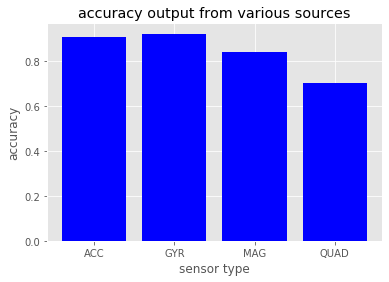

In [27]:
x = ['ACC', 'GYR', 'MAG', 'QUAD']
accuracy = [ACC_accuracy,GYR_accuracy,MAG_accuracy,QUAD_accuracy]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, accuracy, color='blue')
plt.xlabel("sensor type")
plt.ylabel("accuracy")
plt.title("accuracy output from various sources")

plt.xticks(x_pos, x)

plt.show()